In [26]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy import sparse, io
from collections import Counter
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/elegans.h5ad'

scanpy==1.3.2 anndata==0.6.11 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


In [ ]:
df = pd.read_csv("data/NeuronalGeneCount.csv", index_col=0)
/print df.shape

df = df.drop_duplicates(keep='first').T
/print df.shape

df.head()


In [ ]:
df.to_pickle('data/df.pkl')

In [ ]:
df = pd.read_pickle('data/df.pkl')

In [ ]:
np.save('data/elegans/cells.npy', df.index.values)
np.save('data/elegans/genes.npy', df.columns)

In [ ]:
m = sparse.csr_matrix(df.as_matrix().T)

io.mmwrite("data/elegans/matrix.mtx", m)
del m, df

In [193]:
%%time
path = './data/elegans/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = np.load('data/elegans/genes.npy')
adata.obs_names = np.load('data/elegans/cells.npy')



... reading from cache file ./cache/data-elegans-matrix.h5ad
Wall time: 131 ms


In [194]:
adata

AnnData object with n_obs × n_vars = 7603 × 12355 

In [195]:
adata.var_names_make_unique()

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

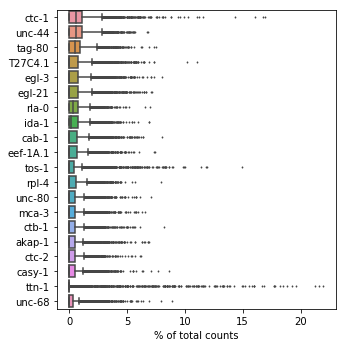

In [196]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filering:

In [197]:
# sc.pp.filter_cells(adata, min_genes=10)
# sc.pp.filter_genes(adata, min_cells=2)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [198]:
# adata.raw = sc.pp.log1p(adata, copy=True)
## TO DO try without raw
sc.pp.log1p(adata, copy=True)


AnnData object with n_obs × n_vars = 7603 × 12355 

In [199]:
%%time
result = sc.pp.filter_genes(adata.X, min_counts=2)  # only consider genes with more than 1 count

filtered out 302 genes that are detected in less than 2 counts
Wall time: 2.99 ms


In [200]:
# from collections import OrderedDict

In [201]:
genesExpressedInOneCell = adata.var_names[~result[0]]
print(genesExpressedInOneCell)

Index(['abf-5', 'amt-4', 'arg-1', 'ceh-40', 'chk-1', 'cof-2', 'col-58',
       'col-69', 'col-92', 'col-142',
       ...
       'F14E5.8', 'F19G12.8', 'F30A10.15', 'C27A2.12', 'K02D10.8', 'C25A11.10',
       'C02B8.12', 'ZK105.12', 'D1046.18', 'R06F6.14'],
      dtype='object', length=302)


In [202]:
sc.pp.filter_genes(adata, min_counts=2) 

filtered out 302 genes that are detected in less than 2 counts


In [203]:
adata

AnnData object with n_obs × n_vars = 7603 × 12053 
    var: 'n_counts'

In [204]:
# sorted(Counter(result[1]))
# OrderedDict(sorted(Counter(result[1]).items(), key=lambda t: t[0]))

In [208]:
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=3000, log=False)
sc.logging.print_memory_usage()

print(Counter(filter_result.gene_subset))

Memory usage: current 0.49 GB, difference -0.01 GB
Counter({False: 9054, True: 2999})


Plot the dispersion relation. Use a logarithmic scale as the data is not yet logarithmized.

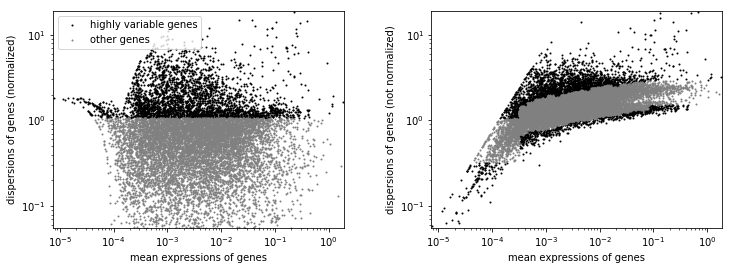

In [209]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

## Remove highly variable genes

In [210]:
adata = adata[:, filter_result.gene_subset]

In [211]:
adata

View of AnnData object with n_obs × n_vars = 7603 × 2999 
    obs: 'n_counts'
    var: 'n_counts'

## PCA

In [212]:
sc.tl.pca(adata, svd_solver='arpack', n_comps = 100)

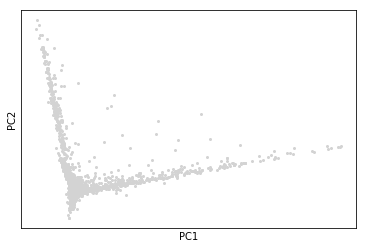

In [213]:
sc.pl.pca(adata)

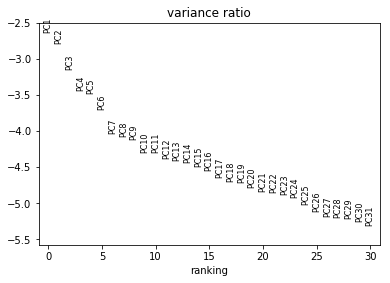

In [214]:
sc.pl.pca_variance_ratio(adata, log=True)

In [215]:
adata

AnnData object with n_obs × n_vars = 7603 × 2999 
    obs: 'n_counts'
    var: 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Neighborhood graph

In [228]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=90)

computing neighbors
    using 'X_pca' with n_pcs = 90
    finished (0:00:02.37) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [229]:
sc.tl.umap(adata)


computing UMAP
    finished (0:00:12.58) --> added
    'X_umap', UMAP coordinates (adata.obsm)


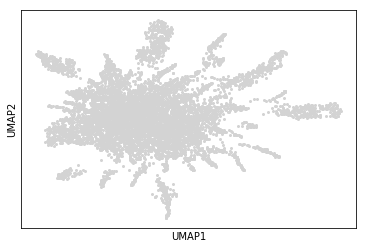

In [230]:
sc.pl.umap(adata)

## Clusters

In [231]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.75) --> found 31 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


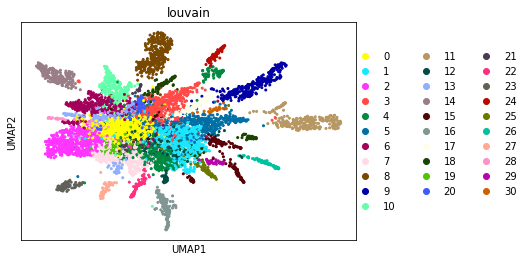

In [232]:
sc.pl.umap(adata, color=['louvain'])

In [233]:
adata.obs['louvain'].value_counts()

0     862
1     732
2     573
3     513
4     431
5     427
6     406
7     331
8     316
9     283
10    282
11    274
12    247
13    233
14    210
15    177
16    150
17    150
18    134
19    121
20    120
21     85
22     79
23     75
24     73
25     69
26     67
27     65
28     46
29     43
30     29
Name: louvain, dtype: int64

## Marker genes

ranking genes
    finished (0:00:00.59) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


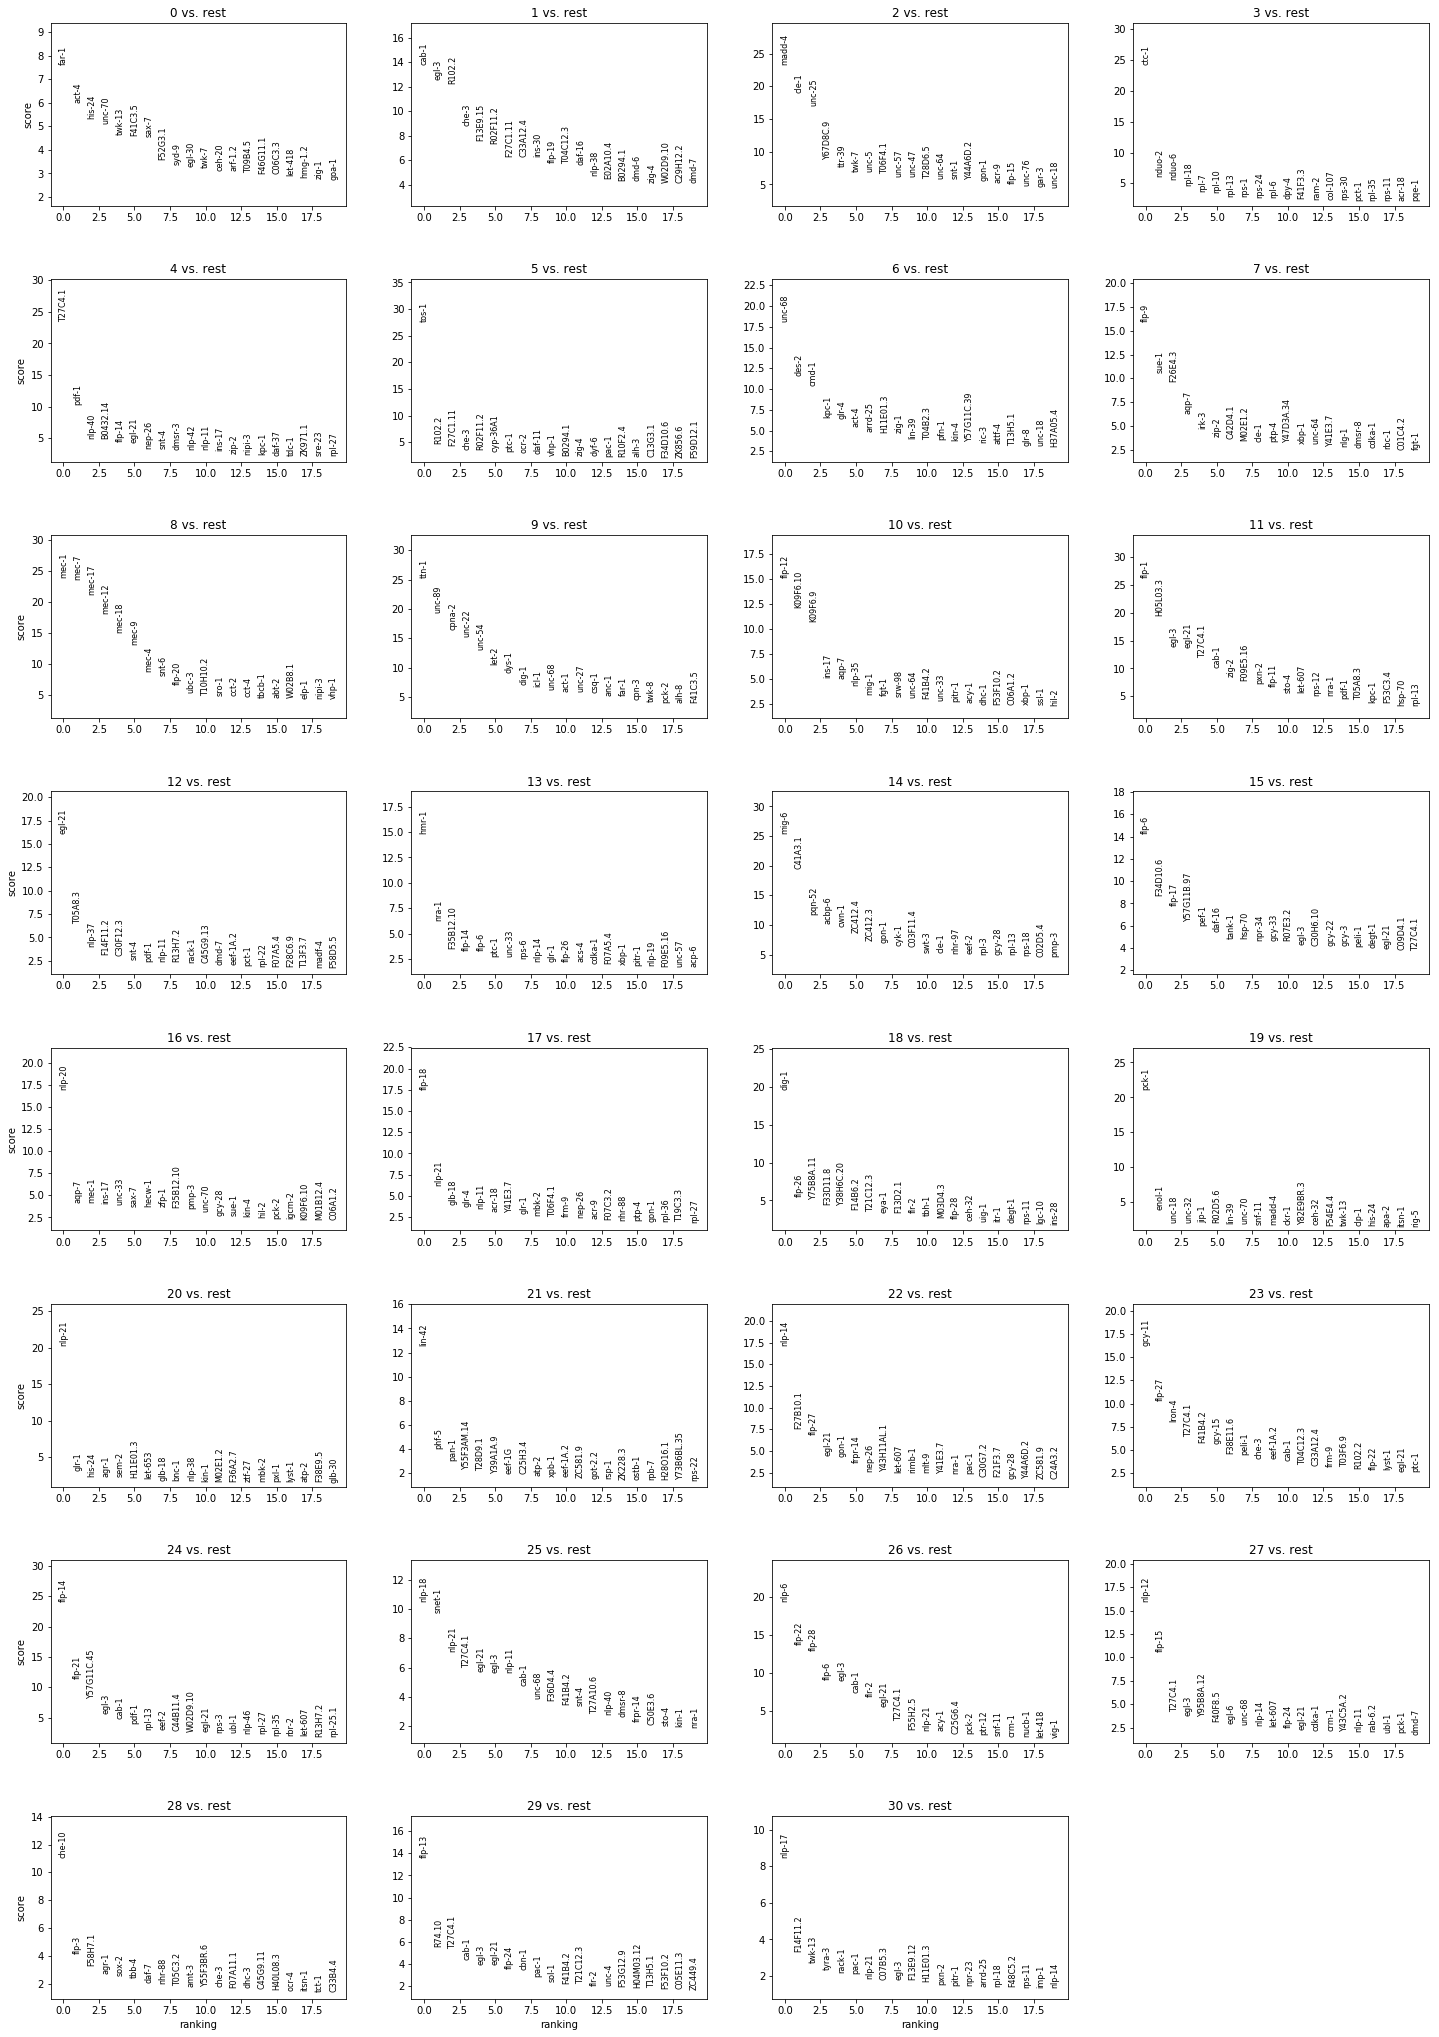

In [234]:
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save='.pdf', )